<a href="https://colab.research.google.com/github/m-wessler/nbm-windgust-better/blob/para-download-branch/WindGustVerify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [403]:
!pip install geopandas
!pip install rtree
!pip install pygeos
!pip install cartopy

import gc
import io
import os
import requests

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime, timedelta

from functools import partial
from multiprocessing import Pool as ProcessPool
from multiprocessing.dummy import Pool as ThreadPool

os.system('tar -xzvf ./output.tar.gz')

512

In [7]:
def str_to_int(_v):
    try:
        return int(_v)
    except:
        return np.nan

In [354]:
# Config
timefmt = '%Y%m%d%H%M'
date0 = datetime(2020, 10, 1, 0, 0)
date1 = datetime(2021, 6, 1, 0, 0)

meta_base = 'https://api.synopticdata.com/v2/stations/metadata?complete=1'
timeseries_base = 'https://api.synopticdata.com/v2/stations/timeseries?'
network_query = '&network=1,2' #1:nws, 2:raws

# Change variable and units here
vars_query = '&vars=wind_gust'
units_query = '&units=english,speed|mph'

api_extras = '&hfmetars=0&qc=on&qc_remove_data=on&qc_flags=off&output=csv'
api_token = '&token=a2386b75ecbc4c2784db1270695dde73'

## Obtain Metadata from SynopticLabs (MesoWest) API

In [355]:
zones_shapefile = './geo/wr_zones_30mr21.shp'
zones_shp = gpd.read_file(zones_shapefile)
cwas_shp = zones_shp.dissolve(by='CWA')
cwa_list = cwas_shp.index

cwa_query = '&cwa=%s'%','.join(cwa_list)
url = meta_base + api_token + network_query + cwa_query
api_return = requests.get(url).json()

metadata = pd.DataFrame(api_return['STATION']).set_index('STID')
metadata = metadata[['NAME', 'CWA', 'LATITUDE', 'LONGITUDE', 'ELEVATION']]
metadata['ELEVATION'] = np.array([str_to_int(v) for v in metadata['ELEVATION']])

metadata = gpd.GeoDataFrame(metadata, geometry=gpd.points_from_xy(
    metadata.LONGITUDE, metadata.LATITUDE))

metadata = gpd.clip(metadata, cwas_shp)

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


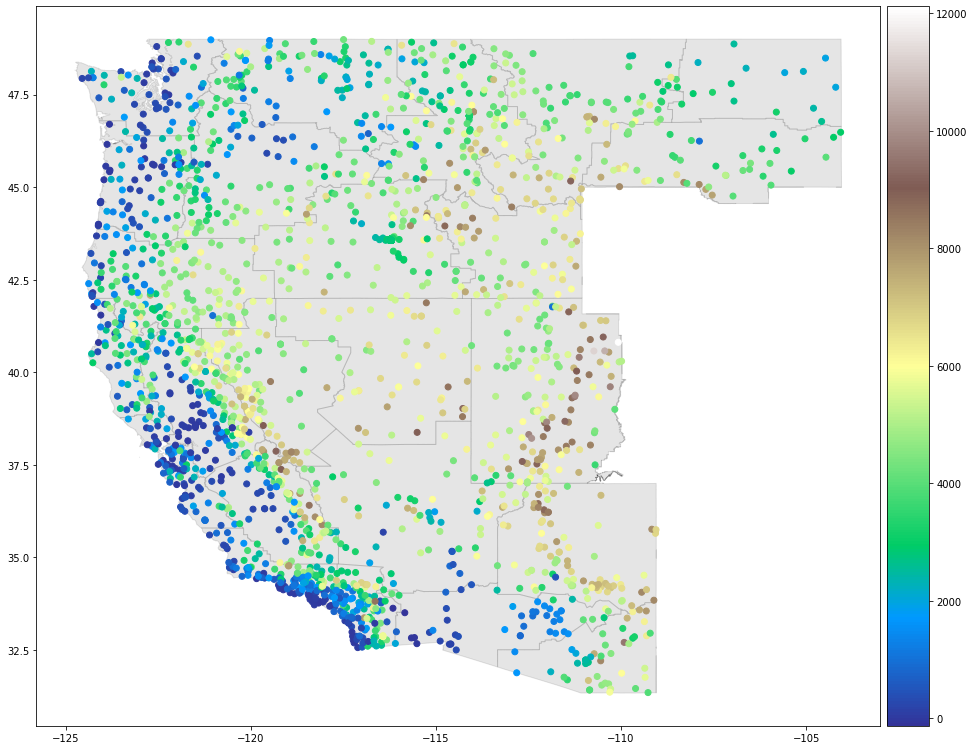

In [47]:
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

def resize_colobar(event):
    # Tell matplotlib to re-draw everything, so that we can get
    # the correct location from get_position.
    plt.draw()

    posn = ax.get_position()
    colorbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                             0.04, axpos.height])

fig, ax = plt.subplots(1, figsize=(16, 16), facecolor='w') 
                       #subplot_kw={'projection': ccrs.PlateCarree()})

cwas_shp.plot(column='NAME', color='k', alpha=0.1, edgecolor='k', 
              ax=ax, zorder=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

meta_plot = metadata.dropna()
metadata.plot(column='ELEVATION', cmap='terrain', 
              legend=True, ax=ax, cax=cax, zorder=11)

# ax.add_feature(cartopy.feature.OCEAN, zorder=100, color=None, edgecolor=None)
# ax.coastlines(linewidth=2, zorder=101)

plt.show()
plt.close()

##Obtain observation data from SynopticLabs (MesoWest) API


In [48]:
def parse_api_request(_url):

    api_return = requests.get(_url).json()
        
    df_agg = []
    for i, station_data in enumerate(api_return['STATION']):

        df = pd.DataFrame(station_data['OBSERVATIONS'])
        df.insert(1, 'stid', station_data['STID'])

        # Update this if using for other variables
        df = df.rename(columns={'wind_gust_set_1':'wind_gust'})

        # Grab only the top of the hour ob (1e9 nanosecond stamp to second)
        # Can play with adjusting the 15 min roundoff to as much as +/- 30
        df['date_time'] = df['date_time'].astype(np.datetime64).round('15min')
        df = df.iloc[np.where(df['date_time'].astype(int)%3600e9== 0)]

        # Faster to sort than search
        df = df.sort_values(by='wind_gust', ascending=True)
        df = df.drop_duplicates(subset='date_time', keep='last')
        df = df.set_index(['date_time', 'stid']).sort_index()

        # Optional, drop NaN (no gust or missing)
        df = df.dropna(how='any')

        if df.size > 0:
            df_agg.append(df)

    return pd.concat(df_agg).sort_index()

In [258]:
# Data limits for this many stations requires we break down the request into
# CWAs first then sub-monthly. Adjust the dates as needed if you're getting errs
date_sets = pd.date_range(date0, date1, freq='15D')

observations = []
for cwa in cwa_list:
    cwa_pickle = './output/%s.gust.pd'%cwa

    if not os.path.isfile(cwa_pickle):
        cwa_data = []
        cwa_query = '&cwa=%s'%cwa

        for start, end in zip(date_sets[:-1], date_sets[1:]):
            print('\rWorking %s, %s'%(start.strftime(timefmt), cwa), end='')

            date_query = '&start=%s&end=%s'%(
                start.strftime(timefmt), end.strftime(timefmt))
                            
            url = (timeseries_base + api_token + cwa_query + network_query +
                date_query + vars_query + api_extras)
            
            cwa_data.append(parse_api_request(url))

        cwa_data = pd.concat(cwa_data)
        cwa_data = cwa_data.loc[cwa_data.index.drop_duplicates()]

        cwa_data.to_pickle('./output/%s.gust.pd'%cwa)
        cwa_data.to_csv('./output/%s.gust.csv'%cwa)

    else:
        cwa_data = pd.read_pickle(cwa_pickle)
    
    observations.append(cwa_data)
observations = pd.concat(observations).sort_index()

# Subset the API returns to sites *actually* within the WR CWAs
subset_index = [i for i, index in 
                enumerate(observations.index.get_level_values(1)) 
                if index in metadata.index]

observations = observations.iloc[subset_index]
observations.index.rename(['valid_time', 'stid'], inplace=True)

observations

wind_gust
date_time  stid            
2020-10-01 ABNW1      2.680
           ACRU1      5.366
           ANBC1      5.813
           ASRC1      7.598
           BAFM8     11.174
...                     ...
2021-05-29 WWCO3     11.621
           WWDC1      2.680
           WWRC1      4.023
           YLPO3      4.918
           YNFO3      4.023

[2063648 rows x 1 columns]

## Obtain NBM Data to Match to Obs

In [414]:
def download_sitedata_wave1d_inner(date, __stid):

    date = pd.to_datetime(date)
        
    # For now pull from the csv generator
    # Best to get API access or store locally later
    base = 'https://hwp-viz.gsd.esrl.noaa.gov/wave1d/data/archive/'
    
    datestr = '{:04d}/{:02d}/{:02d}'.format(date.year, date.month, date.day)
    # Since the wave1d kept 01, 07, 13, 19 inits despite new labels, hour+1
    sitestr = '/NBM4.0/{:02d}/{:s}.csv'.format(date.hour+1, __stid)
    
    url = base + datestr + sitestr
    # print('\r', i, date, url, end='')

    try:
        wave1d_return = requests.get(url)
        site_df_temp = pd.read_csv(
                io.StringIO(wave1d_return.content.decode('utf-8'))
            )[['ValidTime', 'GUST_10 m above ground']]

    except:
        return None

    else:
        site_df_temp['ValidTime'] = [datetime.strptime(t, '%Y%m%d%H') 
            for t in site_df_temp['ValidTime'].astype(str)]

        site_df_temp['init_time'] = date
        site_df_temp['stid'] = __stid

        site_df_temp = site_df_temp.rename(
            columns={'ValidTime':'valid_time', 
                    'GUST_10 m above ground':'wind_gust'}
                    ).set_index(['init_time', 'valid_time', 'stid'])

        lead_time = (
            (site_df_temp.index.get_level_values(1) - date).days*24*3600 + 
            (site_df_temp.index.get_level_values(1) - date).seconds)/3600

        lead_time_index = ((lead_time >= 0) & (lead_time <= 168) & 
                        (lead_time % 6 == 0))

        site_df_temp = site_df_temp[lead_time_index]

        site_df_temp.insert(0, 'lead_time', 
                            lead_time[lead_time_index].astype(int))
        
    return site_df_temp

In [415]:
def download_sitedata_wave1d(_stid, _cwa, _date0, _date1):
    print('Processing %s %s'%(_cwa, _stid))

    site_df = []
    date_list = pd.date_range(_date0, _date1, freq='12h')

    mpifunc_inner = partial(download_sitedata_wave1d_inner, __stid=_stid)
    with ThreadPool(10) as tp:
        site_df = tp.map(mpifunc_inner, date_list)
        tp.close()
        tp.join()

    site_df = [i for i in site_df if i is not None]

    try:
        site_df = pd.concat(site_df).sort_index()
    except:
        return None

    else:
        site_df.to_pickle('./output_nbm/%s.%s.gust.pd'%(
            _cwa.upper(), _stid.upper()))
        
        site_df.to_csv('./output_nbm/%s.%s.gust.csv'%(
            _cwa.upper(), _stid.upper()))
        
        print('%s %s saved'%(_cwa.upper(), _stid.upper()))
        
        return None #site_df # Return dataframe if desired inline

In [416]:
for cwa in metadata['CWA'].unique():
    site_list = metadata[metadata['CWA'] == cwa].index

    print('Processing %d sites for %s CWA'%(site_list.size, cwa))

    mpifunc = partial(download_sitedata_wave1d, 
                        _cwa=cwa, _date0=date0, _date1=date1)
    
    with ProcessPool(1) as pp:
        pp.map(mpifunc, site_list, chunksize=1)
        pp.close()
        pp.join()
        
    break

Processing 140 sites for SLC CWA
Processing SLC KSLC


KeyboardInterrupt: ignored

## Analyze bulk stats, plots, etc...

<function matplotlib.pyplot.show>

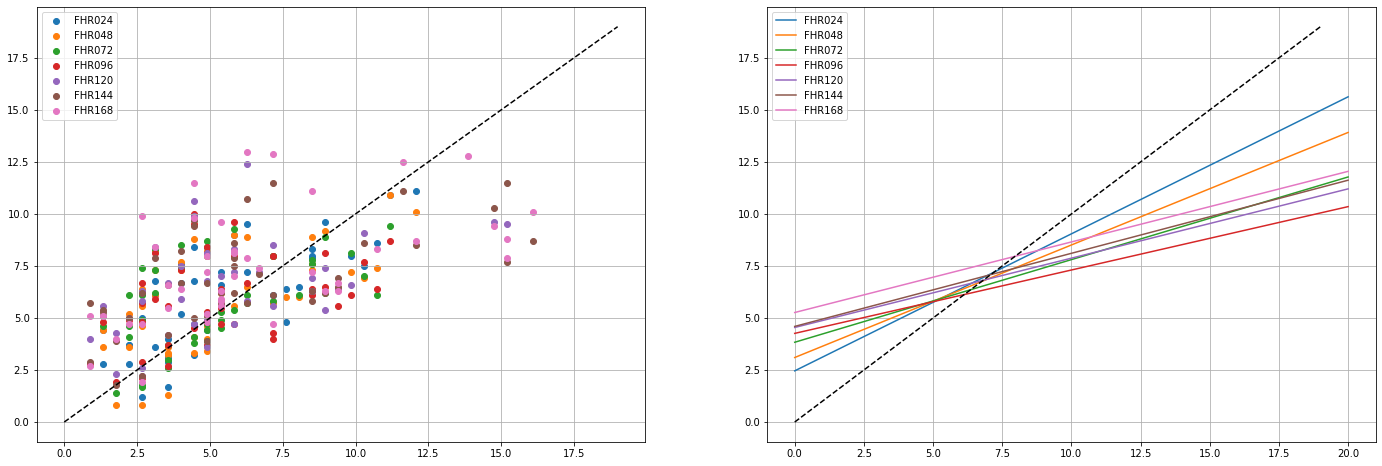

In [344]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8), facecolor='w')
ax1, ax2 = axs

for fhr in np.arange(24, 169, 24):

    test = df_all[df_all['lead_time'] == fhr].reset_index().set_index(['valid_time', 'stid'])
    
    x, y = observations.loc[test.index], test['wind_gust']
    m, b = np.polyfit(x.values.reshape(-1), y.values, 1)

    ax1.scatter(x, y, 
                label='FHR%03d'%fhr)

    ax2.plot(np.linspace(0, 20, 10), m*np.linspace(0, 20, 10)+b, 
             label='FHR%03d'%fhr)

for ax in axs:
    ax.plot(np.arange(0, 20), 'k--')
    ax.grid()
    ax.legend()

plt.show